In [244]:
from __future__ import division, unicode_literals

import pandas as pd
import numpy as np
import math

from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from pandas.tools.plotting import scatter_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl
from IPython.display import Image

# Чтение данных

In [271]:
train = pd.read_csv('train.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')

assert(train.columns[-1] == 'retweet_count')

# train_f = train[['user.statuses_count', 'user.followers_count', 
#                 'user.friends_count', 'user.listed_count', 'user.favourites_count']]

train_f = train[['user.statuses_count', 'user.followers_count', 
                'user.listed_count']]

# Пре-процессинг данных

Размеры данный

In [246]:
print train_f.shape

(67211, 5)


In [247]:
train_f.head()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
0,1606,9164,205,27,758
1,3004,7484,708,330,44
2,3988,2050,491,70,422
3,9018,919,309,38,79
4,32527,85356,912,1232,137


Характеристики данных

In [248]:
train_f.describe()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
count,6.721100e+04,6.721100e+04,6.721100e+04,67211.000000,67211.000000
mean,9.214209e+04,2.493563e+05,6.381893e+03,1829.584012,3488.091994
std,1.990518e+05,1.101774e+06,3.638143e+04,8257.238243,12399.361134
min,6.000000e+00,3.500000e+01,0.000000e+00,0.000000,0.000000
25%,9.716500e+03,8.762000e+03,4.030000e+02,138.000000,111.000000
50%,2.799800e+04,4.064900e+04,9.290000e+02,471.000000,722.000000
75%,7.583100e+04,1.462430e+05,2.659000e+03,1332.000000,2481.000000
max,1.775275e+06,6.622713e+07,3.131983e+06,584387.000000,623798.000000


Построим корреляционную матрицу для оценивания наличия линейной зависимости между признаками. Можно заметить, что признауи не скореллированы, только 'user.listed_count' и 'user.followers_count' имеют коэффициетн = 0.846. Это следует учитывать при построении линейных классификаторов.

In [249]:
train_f.corr()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
user.statuses_count,1.000000,0.052894,0.127003,0.054768,0.024958
user.followers_count,0.052894,1.000000,0.136822,0.845898,0.022280
user.friends_count,0.127003,0.136822,1.000000,0.099393,0.179443
user.listed_count,0.054768,0.845898,0.099393,1.000000,0.020612
user.favourites_count,0.024958,0.022280,0.179443,0.020612,1.000000


Визуализация данных.
Диапазон значений параметров довольно сильно отличается. Пэтому их необходимо преобразовать. Добавим +1 к каждому параметру и прологорифмируем эти значения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12617f590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114f95350>]], dtype=object)

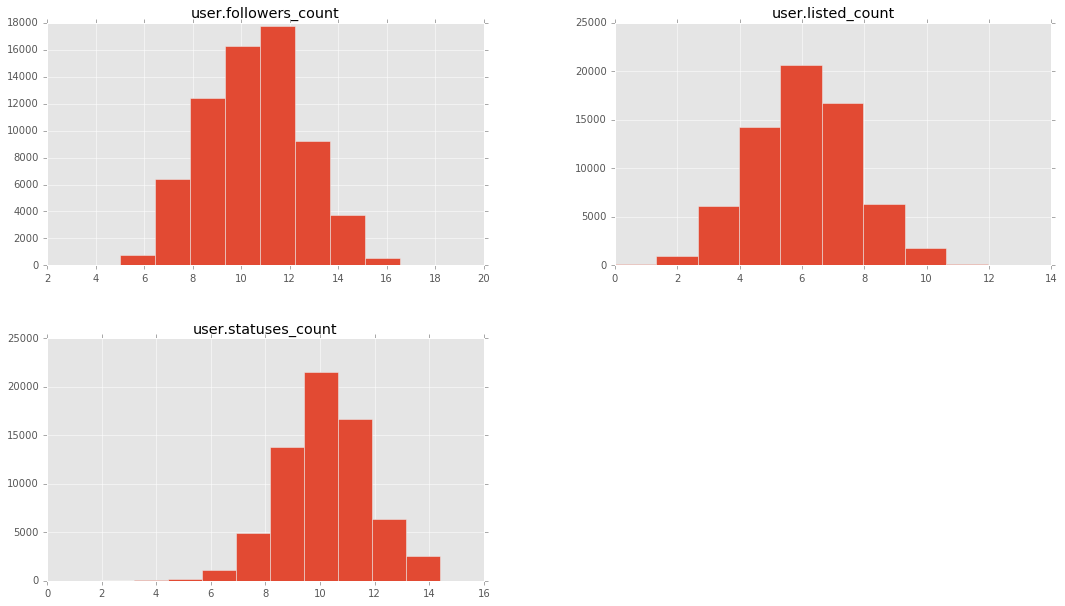

In [272]:
plt.style.use('ggplot')
# init data
# pd.DataFrame.hist(train_f, figsize = [18,10])
train_log = train_f.applymap(lambda x : x + 1).applymap(math.log)
# data ufter log operation
pd.DataFrame.hist(train_log, figsize = [18,10])

# train_log.corr()

# Вычисления признаков

In [273]:
def df2features(df):
    return np.array([
        df['user.statuses_count'],
        df['user.followers_count'],
#         df['user.friends_count'],
        df['user.listed_count'],
#         df['user.favourites_count'],
    ]).transpose()

train_x = df2features(train_log)
train_y = train['retweet_count'] > 20

## Построение моделей

Пример вычисления площади под ROC-кривой на обучающей выборке.

In [274]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, svm

from sklearn.metrics import roc_curve, auc

In [253]:
model_dtc = DecisionTreeClassifier()
model_lr = LogisticRegression(penalty='l1', tol=0.01)

## KNN

С методом knn я провёл эксперимент: решил вяснить, как будет лучше работать модель,

Поиск оптимального значения K для KNN

In [193]:
# search for an optimal value of K for KNN
k_range = range(1, 51, 2)
k_scores = []
k_scores_std = []
for k in k_range:
    model_knc = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model_knc, train_x, train_y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    k_scores_std.append(scores.std())

In [ ]:
scores_max = max(k_scores)
k_optimum = k_range[k_scores.index(scores_max)]
std = k_scores_std[k_scores.index(scores_max)]
print 'scores_max: {}'.format(scores_max)
print 'k_optimum: {}'.format(k_optimum)
print 'std: {}'.format(std)

In [ ]:
# plot the value of K for KNN (x-axis) versus the cross-validated Accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Tune k-param')

Результат 1. KNN, 5 параметров, log data, оптимальный k=17. Accuracy=0.946 , std = 0.002

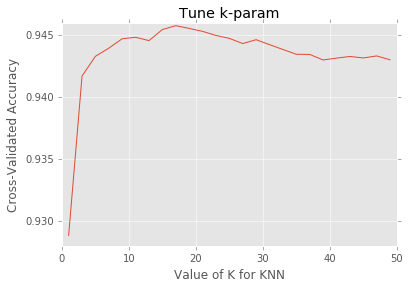

In [187]:
Image(filename='img/k17nn_5par_log.png')

Результат 2. KNN, 3 параметрa, log data, оптимальный k=7. Accuracy=0.945 , std = 0.003

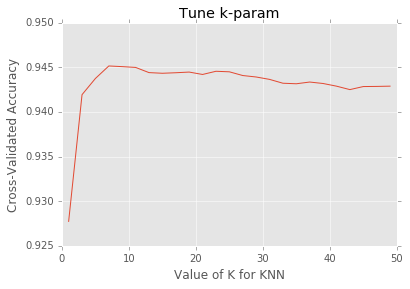

In [188]:
Image(filename='img/k7nn_3par_log.png')

Результат 3. KNN, 5 параметров, initial data, оптимальный k=21. Accuracy=0.945 , std = 0.002

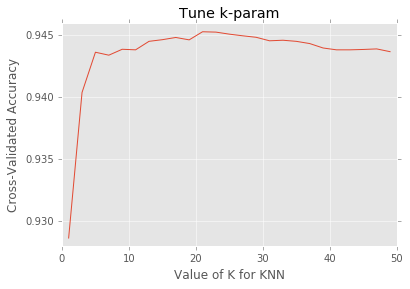

In [173]:
Image(filename='img/k21nn_5par.png')

Результат 4. KNN, 3 параметров, initial data, оптимальный k=15. Accuracy=0.9447 , std = 0.0025

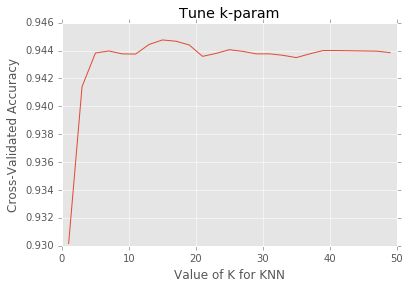

In [196]:
Image(filename='img/k15nn_3par.png')

## Эксперимент

In [11]:
model_knc = KNeighborsClassifier(n_neighbors = 10)

Определение оптимального параметра k при разном разбиении для CV

In [ ]:
# define the parameter values that should be searched
k_range = range(29, 47, 2)
cv_range = range(45, 120, 5)
param_grid = dict(n_neighbors=k_range)
best_score_list = []
best_params_list = []
for cv in cv_range:
    grid = GridSearchCV(model_knc, param_grid, cv=cv, scoring='roc_auc')
    grid.fit(train_x, train_y)
    scores_list = [round(result.mean_validation_score, 3) for result in grid.grid_scores_]
    params_list = [result.parameters['n_neighbors'] for result in grid.grid_scores_]
    best_score = max(scores_list)
    best_score_list.append(best_score)
    best_params_list.append(params_list[scores_list.index(best_score)])

In [ ]:
plt.plot(cv_range, best_score_list)
plt.xlabel('CV param')
plt.ylabel('Best AUC Score')
plt.title('Tune Folds param')

3  ПАРАМЕТРА.
Анплизируя график, тестовую выборку можно поделить на сv = 55 частей(k optimum = 25, AUC mean: 0.868, AUC std: 0.024). Этит мы выиграем в производительности, в сравнении с cv = 55 и практически не теряя точности. 3 параметра: 'user.followers_count', 'user.friends_count'. 'user.listed_count'. Log data

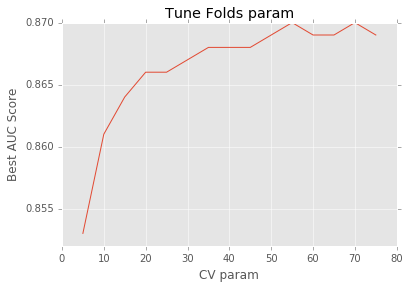

In [12]:
Image(filename='img/knn_3par_log.png')

5  ПАРАМЕТРОВ.
Анплизируя график, тестовую выборку можно поделить на сv = 75 частей(k optimum = 41, AUC mean: 0.889, AUC std: 0.023). Log data

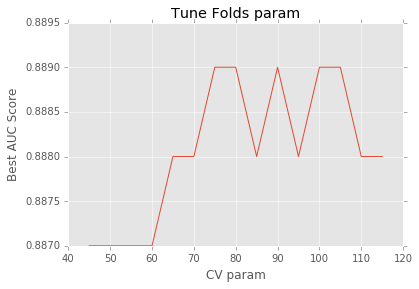

In [13]:
Image(filename='img/knn_5par_log.png')

5 ПАРАМЕТРОВ. Анплизируя график, тестовую выборку можно поделить на сv = 100 частей(k optimum = 31, AUC mean: 0.885, AUC std: 0.027). Initial data

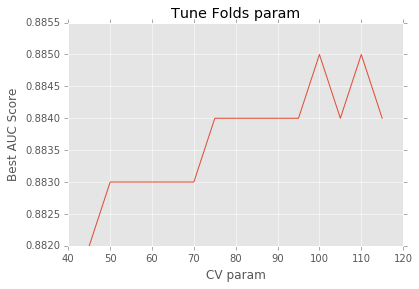

In [14]:
Image(filename='img/knn_5par.png')

3 ПАРАМЕТРА. Анплизируя график, тестовую выборку можно поделить на сv = 65 частей(k optimum = 31, AUC mean: 0.865, AUC std: 0.025). Initial data

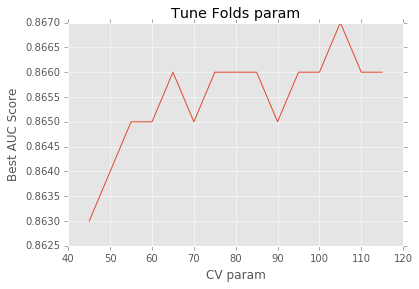

In [15]:
Image(filename='img/knn_3par.png')

Прогноз с подобранными параметрами. В качестве получения тренировочных и проверочных выборок будем использовать StratifiedKFold, GridSearchCV также её испльзует

### Обучение моделей KNN с оптимальными параметрами

In [ ]:
folds = 75
model_knc = KNeighborsClassifier(n_neighbors = 41)
skf = StratifiedKFold(train_y, n_folds=folds)
auc_list = []
delta = []

for train_index, test_index in skf:
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    model_knc.fit(X_train, y_train)
    proba = model_knc.predict_proba(X_test)
    auc = roc_auc_score(y_test, proba[:,1])
    auc_list.append(auc)

# to check the profit from multi knn algorithms
    auc_list2 = []
    y_train = y_train.values
    skf2 = StratifiedKFold(y_train, n_folds=folds)
    for train_index2, test_index2 in skf2:
        X_train2, X_test2 = X_train[train_index2], X_train[test_index2]
        y_train2, y_test2 = y_train[train_index2], y_train[test_index2]
        model_knc.fit(X_train2, y_train2)
        proba = model_knc.predict_proba(X_test2)
        auc2 = roc_auc_score(y_test2, proba[:,1])
        auc_list2.append(auc2)
    auc2_mean = np.mean(auc_list2)
    delta.append(auc2_mean - auc)
    print auc2_mean - auc

unit_profit = sum(delta)/len(delta)
print unit_profit

Значение переменной unit_profit получилось -0.000814. Это говорит о том, что использование набора knn алгоритмов и жертвуя частью тестовых данных не приносит выгоды.
Для кросс валидации разобъём данные на тестовую и проверочную выборку в соотношении 1/9. Найдём оптимальное число соседей k.

## LogisticRegression

In [261]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=10)
grid.fit(train_x, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty=u'l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={u'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [262]:
clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
rfe = RFE(model_lr, 3)
rfe = rfe.fit(train_x, train_y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

Кросс-валидация

In [ ]:
train_x_ROC, test_x_ROC, train_y_ROC, test_y_ROC = cross_validation.train_test_split(train_x, train_y, test_size=0.2)

In [ ]:
kfold = 5 #количество подвыборок для валидации
acc_val = {}
scores = cross_validation.cross_val_score(model_dtc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['DecisionTreeClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_lr, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['LogisticRegression'] = scores.mean()
scores = cross_validation.cross_val_score(model_rfc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['RandomForestClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['KNeighborsClassifier'] = scores.mean()


In [ ]:
plt.bar(range(len(acc_val)), acc_val.values(), align='center')
plt.xticks(range(len(acc_val)), acc_val.keys(), rotation='vertical')
pl.ylabel('Accuracy')
plt.show()

# Random Forest

Иллюстрирование Feature importances

In [ ]:
model_rfc = RandomForestClassifier(n_estimators = 35)
model_rfc.fit(train_x, train_y)
feature_names = train_log.columns.values

importances = model_rfc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

In [ ]:
d_first = 5
plt.figure(figsize=(5, 5))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

Feature importances:
 1. feature 'user.statuses_count' (0.3110)
 2. feature 'user.followers_count' (0.2846)
 3. feature 'user.statuses_count' (0.1717)
 4. feature 'user.listed_count' (0.1215)
 5. feature 'user.favourites_count' (0.1111)
 
1. n=10: acc = 0.9423| 0.9423
2. n=30: acc=0.9434 | 0.9435
3. n=100: acc=0.9447 | 0.94404
4. n=300: acc = 0.9442 | 0.94499

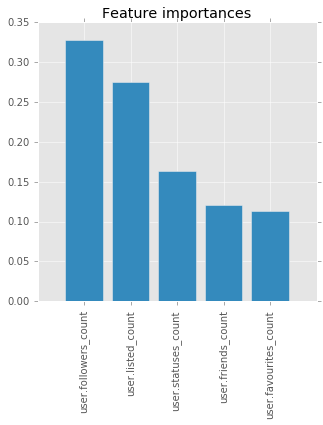

In [228]:
Image(filename='img/rfc_feature_importan.png')

Поиск оптимального числа деревьев. 3 признака

In [ ]:
n_range = range(20, 300, 5)
n_scores = []
n_scores_std = []
for n in n_range:
    model_rfc = RandomForestClassifier(n_estimators = n)
    scores = cross_val_score(model_rfc, train_x, train_y, cv=10, scoring='accuracy')
    n_scores.append(scores.mean())
    n_scores_std.append(scores.std())

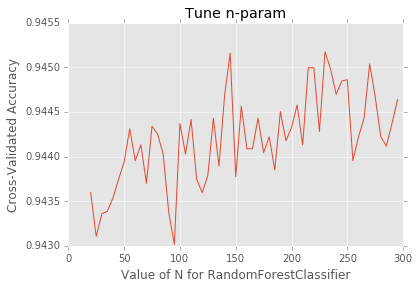

In [225]:
# plot the value of n for RandomForestClassifier (x-axis) versus the cross-validated Accuracy (y-axis)
plt.plot(n_range, n_scores)
plt.xlabel('Value of N for RandomForestClassifier')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Tune n-param')

Результат. RFC, 3 параметроа, log data, оптимальный n=145. Accuracy=0.945 , std = 0.003

## Визуализация ROC-кривой

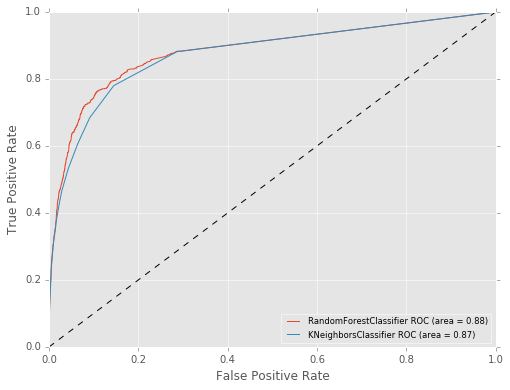

In [289]:
model_knc = KNeighborsClassifier(n_neighbors = 17)
model_rfc = RandomForestClassifier(n_estimators = 145)
train_x_ROC, test_x_ROC, train_y_ROC, test_y_ROC = cross_validation.train_test_split(train_x, train_y, test_size=0.2)
pl.clf()
plt.figure(figsize=(8,6))
# #DecisionTreeClassifier
# probas = model_dtc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
# fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
# roc_auc  = auc(fpr, tpr)
# pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('DecisionTreeClassifier',roc_auc))
#LogisticRegression
# probas = model_lr.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
# fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
# roc_auc  = auc(fpr, tpr)
# pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
#RandomForestClassifier
probas = model_rfc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForestClassifier',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))

pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

# Построение и запись финального прогноза

В тестовых данных были онаружены отрицательные значения.

In [275]:
test = pd.read_csv('test.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')
prediction = pd.read_csv('prediction.csv')

# test_f = test[['user.statuses_count', 'user.followers_count', 
#                 'user.friends_count', 'user.listed_count', 'user.favourites_count']]

test_f = test[['user.statuses_count', 'user.followers_count', 
                'user.listed_count']]
test_log = test_f.abs().applymap(lambda x : x + 1).applymap(math.log)
test_X = df2features(test_log)

Строим новый прогноз и обновляем вероятности того, что ретвитов больше 20.

In [276]:
# model = KNeighborsClassifier(n_neighbors = 17)
model = RandomForestClassifier(n_estimators = 145)

model.fit(train_x, train_y)
proba = model.predict_proba(test_X)

In [278]:
prediction['probability']= proba[:,1]
prediction.to_csv('prediction_rfc.csv', index=False)

In [285]:
prediction = pd.read_csv('prediction_rfc.csv')
prediction2 = pd.read_csv('prediction_knc.csv')